In [1]:
lts = sc.textFile('data/transm150720.csv')

In [2]:
lts.first()

u'79062005698500,TKTT,30,150719,FR,0.0,EUR,T,T,141025,PARA127A8,0.0,EUR,   ,EX,,150719,0.0'

In [3]:
def getTCNFechaCompra(l):
    elems = l.split(",")
    tcn = elems[0]
    fechaCompra = elems[9]
    return (tcn, fechaCompra)

In [4]:
getTCNFechaCompra(lts.first())

(u'79062005698500', u'141025')

In [5]:
ts = lts.map(getTCNFechaCompra)

In [6]:
ts.take(3)

[(u'79062005698500', u'141025'),
 (u'79062005924069', u'150719'),
 (u'79065668570385', u'150626')]

In [7]:
lcs = sc.textFile('data/coupon150720.csv')

In [8]:
lcs.first()

u'79062005698500,1,MAA,AUH,9W,9W,56.79,USD,1,H,H,0526,150904,OK,IAF0'

In [9]:
def getTCNFechaSalida(l):
    elems = l.split(",")
    tcn = elems[0]
    fechaSalida = elems[12]
    return (tcn, fechaSalida)

In [10]:
cs = lcs.map(getTCNFechaSalida)

In [11]:
cs.take(3)

[(u'79062005698500', u'150904'),
 (u'79062005698500', u'150905'),
 (u'79062005924069', u'150721')]

In [15]:
cs.groupByKey().mapValues(lambda vs: min(vs)).take(3)

[(u'79062005558463', u'150801'),
 (u'79065668432713', u'150823'),
 (u'79062005501193', u'150720')]

In [19]:
cgps = cs.groupByKey().mapValues(lambda vs: min(vs)).cache()

In [18]:
cgps.take(3)

[(u'79062005558463', u'150801'),
 (u'79065668432713', u'150823'),
 (u'79062005501193', u'150720')]

In [20]:
j = cgps.leftOuterJoin(ts).cache()

In [21]:
j.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [22]:
from time import strptime
from time import mktime

In [23]:
def difFechas(f1,f2):
    of1 = strptime(f1,'%y%m%d')
    of2 = strptime(f2,'%y%m%d')
    segs1 = mktime(of1)
    segs2 = mktime(of2)
    dif = segs1 - segs2
    return dif/(3600*24)

In [24]:
j.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [26]:
fj = j.filter(lambda x: x[1][0] != '' and x[1][1] != '')

In [27]:
fj.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [28]:
fj.mapValues(lambda v: difFechas(v[0], v[1])).take(3)

[(u'79062005994272', 1.0), (u'79065668614400', 5.0), (u'79062005501193', 1.0)]

In [29]:
d = fj.mapValues(lambda v: difFechas(v[0], v[1]))

In [30]:
d.groupBy(lambda x: x[1]).take(3) ## NO NOS VALE!

[(0.0, <pyspark.resultiterable.ResultIterable at 0x7f1bbe98e650>),
 (750.0, <pyspark.resultiterable.ResultIterable at 0x7f1bbd7d3bd0>),
 (198.04166666666666,
  <pyspark.resultiterable.ResultIterable at 0x7f1bbd7d3c50>)]

In [31]:
d.take(3)

[(u'79062005994272', 1.0), (u'79065668614400', 5.0), (u'79062005501193', 1.0)]

In [32]:
d.map(lambda x: (x[1],1)).take(3)

[(1.0, 1), (5.0, 1), (1.0, 1)]

In [33]:
d.map(lambda x: (x[1],1)).reduceByKey(lambda e,accum: e+accum).take(3)

[(0.0, 28366), (750.0, 1), (198.04166666666666, 126)]

In [34]:
d.map(lambda x: (int(x[1]),1)).reduceByKey(lambda e,accum: e+accum).take(3)

[(0, 28366), (515, 1), (5, 16793)]

In [35]:
r = d.map(lambda x: (int(x[1]),1)).reduceByKey(lambda e,accum: e+accum)

In [36]:
r.take(3)

[(0, 28366), (515, 1), (5, 16793)]

In [37]:
r.count()

452

In [38]:
res = r.collect()

In [39]:
len(res)

452

In [40]:
type(res)

list

In [41]:
res[0:5]

[(0, 28366), (515, 1), (5, 16793), (10, 9906), (15, 7791)]

In [42]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [43]:
xs = [t[0] for t in res]

In [44]:
xs[0:5]

[0, 515, 5, 10, 15]

In [45]:
ys = [t[1] for t in res]

In [47]:
ys[0:5]

[28366, 1, 16793, 9906, 7791]

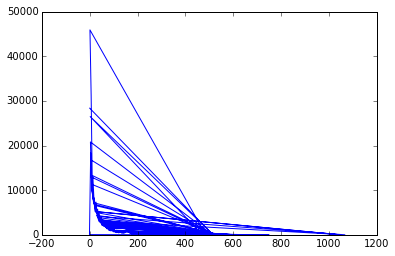

In [48]:
plt.plot(xs,ys)

(0, 90)

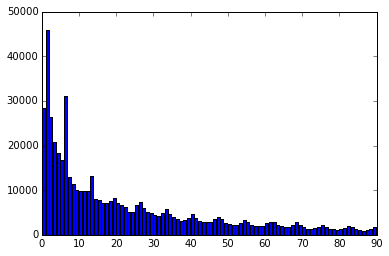

In [52]:
plt.bar(xs,ys)
plt.xlim(0,90)